# NetColoc analysis of gene in the module detected by WGCNA (here, yellow module from the mastitis GSE51856 (Milk).





# _Obtain input gene sets and interactome_

## 1. Load required packages

In [1]:
# load required packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import re
import random

from IPython.display import display

import getpass
import ndex2

import json
import cdapsutil

from gprofiler import GProfiler
gp = GProfiler("MyToolName/0.1")

from scipy.stats import hypergeom
from scipy.stats import norm

# latex rendering of text in graphs
import matplotlib as mpl
mpl.rc('text', usetex = False)
mpl.rc('font', family = 'serif')

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

sns.set(font_scale=1.4)

sns.set_style('white')

sns.set_style("ticks", {"xtick.major.size": 15, "ytick.major.size": 15})
plt.rcParams['svg.fonttype'] = 'none'

from datetime import datetime
import sys
%matplotlib inline

In [2]:
# verify DDOT was installed
import ddot

from netcoloc import netprop_zscore, netprop, network_colocalization, validation


## 2. Select one gene set of interest as well as one gene set from all genes. Load gene set from text files into python.


Identify one gene sets of interest. Gene sets should come from experimental data (not manual curation) to avoid bias. 

**Usage Note**: gene sets should be < 500 genes (propagation algorithm breaks down if seeded with larger sets). If your gene set is larger, only use the top 500 as seeds to the network propagation.



In [25]:
# set names of geneset 1
g1_name='Grey'

# load the genes of the module of interest
G1_df = pd.read_csv('Data/Grey.tsv')
G1_df.index = G1_df['gene']
print('Number of '+g1_name+' genes:', len(G1_df))
G1_genes = G1_df.index.tolist() # define rare variant genes to seed network propagation
print("First 5 genes:", G1_genes[0:5])

print('')


# set names of geneset 1
d1_name='Yellow'

# load the genes of the module of interest
D1_df = pd.read_csv('Data/Yellow.tsv')
D1_df.index = D1_df['gene']
print('Number of '+d1_name+' genes:', len(D1_df))
D1_genes = D1_df.index.tolist() # define rare variant genes to seed network propagation
print("First 5 genes:", D1_genes[0:5])

print('')


# set names of geneset 1 KME>0.7
d1kme_name='Yellow_KME'

# load the genes of the module of interest
D1kme_df = pd.read_csv('Data/Yellow_KME0.7.tsv')
D1kme_df.index = D1kme_df['gene']
print('Number of '+d1kme_name+' genes:', len(D1kme_df))
D1kme_genes = D1kme_df.index.tolist() # define rare variant genes to seed network propagation
print("First 5 genes:", D1kme_genes[0:5])

print('')


# set names of geneset All
All_name='All'

# load the genes of the module of interest
All_df = pd.read_csv('Data/All_Cattle.tsv')
All_df.index = All_df['gene']
print('Number of '+All_name+' genes:', len(All_df))
All_genes = All_df.index.tolist() # define rare variant genes to seed network propagation
print("First 5 genes:", All_genes[0:5])


Number of Grey genes: 1119
First 5 genes: ['AADAT', 'ABCA6', 'ABCB11', 'ABCB9', 'ABCC11']

Number of Yellow genes: 549
First 5 genes: ['ZPR1', 'ZNF638', 'ZNF614', 'ZNF410', 'ZNF226']

Number of Yellow_KME genes: 124
First 5 genes: ['ABHD13', 'ADA2', 'ADGRE5', 'AKIRIN1', 'ARL6IP6']

Number of All genes: 18860
First 5 genes: ['20ALPHA-HSD', '5_8S_rRNA', '5S_rRNA', '7SK', 'A1BG']


## 3. Select gene interaction network to use for the analysis.

Identify network UUID on NDEx (ndexbio.org) and use this to import to this Jupyter notebook. We recommend using PCNet as a starting point, but a user may want to switch to “STRING high confidence” if using a machine with low memory (< 8GB RAM).


In [4]:
interactome_uuid='4de852d9-9908-11e9-bcaf-0ac135e8bacf' # for PCNet
# interactome_uuid='275bd84e-3d18-11e8-a935-0ac135e8bacf' # for STRING high confidence
ndex_server='public.ndexbio.org'
ndex_user=None
ndex_password=None
G_int = ndex2.create_nice_cx_from_server(
            ndex_server, 
            username=ndex_user, 
            password=ndex_password, 
            uuid=interactome_uuid
        ).to_networkx()
nodes = list(G_int.nodes)

# remove self edges from network
G_int.remove_edges_from(nx.selfloop_edges(G_int))

# print out the numbers of nodes and edges in the interatome for diagnostic purposes:
print('Number of nodes:', len(G_int.nodes))
print('\nNumber of edges:', len(G_int.edges))

Number of nodes: 18820

Number of edges: 2693109


In [5]:
int_nodes = list(G_int.nodes)

## 5. Subset the genes to those found in the selected network. 

Only genes contained in the interaction network will be retained for downstream analysis. 


In [26]:
# subset the genes to those found in interactome

print("Number of G1 genes:", len(G1_df))
G1_df = list(np.intersect1d(G1_df,int_nodes))
print("Number of G1 genes in interactome:", len(G1_genes))
G1_df = pd.DataFrame(G1_df, columns=['gene']) 

print("Number of D1 genes:", len(D1_df))
D1_df = list(np.intersect1d(D1_df,int_nodes))
print("Number of D1 genes in interactome:", len(D1_genes))
D1_df = pd.DataFrame(D1_df, columns=['gene']) 

print("Number of D1_KME genes:", len(D1kme_df))
D1kme_df = list(np.intersect1d(D1kme_df,int_nodes))
print("Number of D1_KME genes in interactome:", len(D1kme_genes))
D1kme_df = pd.DataFrame(D1kme_df, columns=['gene']) 

print("Number of All genes:", len(All_genes))
All_df = list(np.intersect1d(All_df,int_nodes))
print("Number of All genes in interactome:", len(All_df))
All_df = pd.DataFrame(All_df, columns=['gene']) 

Number of G1 genes: 1119
Number of G1 genes in interactome: 1119
Number of D1 genes: 549
Number of D1 genes in interactome: 549
Number of D1_KME genes: 124
Number of D1_KME genes in interactome: 124
Number of All genes: 18860
Number of All genes in interactome: 15560


# _Identify network colocalized gene network_

## 4. Precalculate matrices needed for propagation. This step should take a few minutes (more for larger/denser networks) 

A benchmarking analysis demonstrates that the runtime required scales with the number of edges (w’) and the number of nodes (w’’). NetColoc includes functionality for saving and loading these matrices, by setting the XXX parameter, which can be useful if running multiple analyses. The diffusion parameter, which controls the rate of propagation through the network, may be set in this step. In practice, we have found that results are not dependent on the choice of this parameter, and recommend using the default value of 0.5.

Background on network propagation: https://www.nature.com/articles/nrg.2017.38.pdf?origin=ppub


In [7]:
# pre-calculate matrices used for network propagation. this step takes a few minutes, more for denser interactomes
print('\ncalculating w_prime')
#w_prime = netprop.get_normalized_adjacency_matrix(G_int, conserve_heat=True)

print('\ncalculating w_double_prime')
#w_double_prime = netprop.get_individual_heats_matrix(w_prime, .5)

# w_double_prime can be saved to the file netcoloc_w_double_prime.npy
# in current working directory with the following call:
#
#np.save('netcoloc_w_double_prime.npy', w_double_prime)

# and reloaded later with:
w_double_prime = np.load('netcoloc_w_double_prime.npy')
#
# NOTE: Saving w_double_prime results in a several gigabyte file and
#       takes a minute or more to save and load



calculating w_prime

calculating w_double_prime


#                Run all the processes  

In [130]:
# A random set of genes is extracted from D1, G1 and All groups and 
# network proximity is computed.



import random
import openpyxl



######## Define the variables

random.seed(100)  # Replace 42 with any number to act as a seed

zthresh=2 # default = 3

results_G1_propag = []
results_D1_propag = []
results_All_propag = []

results_G1_common = []
results_D1_common = []
results_All_common = []

results_D1_common_Nodes = []

########



######## Run the main analysis

for x in range(100):
    
    print("Iteration",x, " *************************")
    
    
    # Select a random genes from the D1 as well as All genes
    G1_random = G1_df.sample(n=round(0.25*len(D1_genes)))
    G1_random.index = G1_random['gene']
    G1_random_genes = G1_random.index.tolist()
        
    D1_random = D1_df.sample(n=round(0.25*len(D1_genes)))
    D1_random.index = D1_random['gene']
    D1_random_genes = D1_random.index.tolist()
    
    All_random = All_df.sample(n=round(0.25*len(D1_genes)))
    All_random.index = All_random['gene']
    All_random_genes = All_random.index.tolist()
    
    
    # Compute network proximity scores from tha random seed gene set as well as random all genes
    z_G1, Fnew_G1, Fnew_rand_G1 = netprop_zscore.calculate_heat_zscores(w_double_prime, int_nodes, 
                                  dict(G_int.degree), G1_random_genes, 
                                   num_reps=1000,  minimum_bin_size=100)
    z_G1 = pd.DataFrame({'z':z_G1})
    
    
    z_D1, Fnew_D1, Fnew_rand_D1 = netprop_zscore.calculate_heat_zscores(w_double_prime, int_nodes, 
                                  dict(G_int.degree), D1_random_genes, 
                                   num_reps=1000,  minimum_bin_size=100)
    z_D1 = pd.DataFrame({'z':z_D1})
    
    
    z_All, Fnew_All, Fnew_rand_All = netprop_zscore.calculate_heat_zscores(w_double_prime, int_nodes, 
                                   dict(G_int.degree), All_random_genes,
                                   num_reps=1000, minimum_bin_size=100)
    z_All = pd.DataFrame({'z':z_All})
    
    
    
    
    # select the genes in the network intersection, make a subgraph
    G_G_prox = nx.subgraph(G_int,z_G1[z_G1['z']>zthresh].index.tolist()) 
    G_prox = nx.subgraph(G_int,z_D1[z_D1['z']>zthresh].index.tolist()) 
    G_All_prox = nx.subgraph(G_int,z_All[z_All['z']>zthresh].index.tolist()) 

    
    D1_seed = set(D1_genes) - set(D1_random_genes)
    D1_common = set(G_prox.nodes) & set(D1_seed)
    
    
    results_D1_common_Nodes.append(D1_common)
    
        
    
    G1_seeds = set(D1_genes) - set(G1_random_genes)
    G1_common = set(G_G_prox.nodes) & set(G1_seeds)
    
   
    All_seeds = set(D1_genes) - set(All_random_genes)
    All_common = set(G_All_prox.nodes) & set(All_seeds)
    
    
    results_G1_propag.append(len(G_G_prox.nodes()))
    results_D1_propag.append(len(G_prox.nodes()))
    results_All_propag.append(len(G_All_prox.nodes()))
    
    results_G1_common.append(len(G1_common))
    results_D1_common.append(len(D1_common))
    results_All_common.append(len(All_common))
    
    print("End of Iteration",x, " ******************")
    
########    


            

Iteration 0  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 0  ******************
Iteration 1  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 1  ******************
Iteration 2  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 2  ******************
Iteration 3  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 3  ******************
Iteration 4  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 4  ******************
Iteration 5  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 5  ******************
Iteration 6  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 6  ******************
Iteration 7  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 7  ******************
Iteration 8  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 8  ******************
Iteration 9  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 9  ******************
Iteration 10  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 10  ******************
Iteration 11  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 11  ******************
Iteration 12  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 12  ******************
Iteration 13  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 13  ******************
Iteration 14  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 14  ******************
Iteration 15  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 15  ******************
Iteration 16  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 16  ******************
Iteration 17  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 17  ******************
Iteration 18  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 18  ******************
Iteration 19  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 19  ******************
Iteration 20  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 20  ******************
Iteration 21  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 21  ******************
Iteration 22  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 22  ******************
Iteration 23  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 23  ******************
Iteration 24  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 24  ******************
Iteration 25  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 25  ******************
Iteration 26  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 26  ******************
Iteration 27  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 27  ******************
Iteration 28  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 28  ******************
Iteration 29  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 29  ******************
Iteration 30  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 30  ******************
Iteration 31  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 31  ******************
Iteration 32  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 32  ******************
Iteration 33  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 33  ******************
Iteration 34  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 34  ******************
Iteration 35  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 35  ******************
Iteration 36  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 36  ******************
Iteration 37  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 37  ******************
Iteration 38  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 38  ******************
Iteration 39  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 39  ******************
Iteration 40  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 40  ******************
Iteration 41  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 41  ******************
Iteration 42  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 42  ******************
Iteration 43  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 43  ******************
Iteration 44  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 44  ******************
Iteration 45  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 45  ******************
Iteration 46  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 46  ******************
Iteration 47  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 47  ******************
Iteration 48  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 48  ******************
Iteration 49  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 49  ******************
Iteration 50  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 50  ******************
Iteration 51  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 51  ******************
Iteration 52  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 52  ******************
Iteration 53  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 53  ******************
Iteration 54  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 54  ******************
Iteration 55  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 55  ******************
Iteration 56  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 56  ******************
Iteration 57  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 57  ******************
Iteration 58  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 58  ******************
Iteration 59  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 59  ******************
Iteration 60  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 60  ******************
Iteration 61  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 61  ******************
Iteration 62  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 62  ******************
Iteration 63  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 63  ******************
Iteration 64  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 64  ******************
Iteration 65  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 65  ******************
Iteration 66  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 66  ******************
Iteration 67  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 67  ******************
Iteration 68  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 68  ******************
Iteration 69  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 69  ******************
Iteration 70  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 70  ******************
Iteration 71  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 71  ******************
Iteration 72  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 72  ******************
Iteration 73  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 73  ******************
Iteration 74  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 74  ******************
Iteration 75  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 75  ******************
Iteration 76  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 76  ******************
Iteration 77  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 77  ******************
Iteration 78  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 78  ******************
Iteration 79  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 79  ******************
Iteration 80  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 80  ******************
Iteration 81  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 81  ******************
Iteration 82  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 82  ******************
Iteration 83  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 83  ******************
Iteration 84  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 84  ******************
Iteration 85  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 85  ******************
Iteration 86  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 86  ******************
Iteration 87  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 87  ******************
Iteration 88  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 88  ******************
Iteration 89  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 89  ******************
Iteration 90  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 90  ******************
Iteration 91  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 91  ******************
Iteration 92  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 92  ******************
Iteration 93  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 93  ******************
Iteration 94  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 94  ******************
Iteration 95  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 95  ******************
Iteration 96  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 96  ******************
Iteration 97  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 97  ******************
Iteration 98  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 98  ******************
Iteration 99  *************************


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

End of Iteration 99  ******************


RuntimeError: Invalid response: 504 
<html>
<head><title>504 Gateway Time-out</title></head>
<body>
<center><h1>504 Gateway Time-out</h1></center>
<hr><center>nginx</center>
</body>
</html>


In [142]:
# Results of network proximity is organized and enrichment analysis as 
# well as statistical analysis is performed.


######## Prepare the output of the main analysis

data = {
'Nu.Propagated.D1': results_D1_propag,
'Nu.Common.D1': results_D1_common,
'Nu.Propagated.Grey': results_G1_propag,
'Nu.Common.Grey': results_G1_common,
'Nu.Propagated.All': results_All_propag,
'Nu.Common.All': results_All_common
}


# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Save the DataFrame to an Excel file
#df.to_excel('Results_Yellow.xlsx', index=False, engine='openpyxl')
########  
    
    

    
    
######## Save the genes that were propagated in most of the iterationes  

from collections import Counter

##### Find the genes that were propagated in all iterationes
intersection = set(results_D1_common_Nodes[0]).intersection(*results_D1_common_Nodes)

intersection = pd.DataFrame(intersection)

#####



##### Find the genes that were propagated in 50% of the iterationes

# Flatten the list of lists and count occurrences of each gene
all_genes = []
for sublist in results_D1_common_Nodes:
    for gene in sublist:
        all_genes.append(gene)


gene_counts = Counter(all_genes)

# Find genes that meet or exceed the threshold
overlap_genes = []

for gene, count in gene_counts.items():
    if count >= 30:
        overlap_genes.append(gene)

overlap_genes = pd.DataFrame(overlap_genes)

#####

########



######## Enrichment analysis 

import enrichrpy.enrichr as een
import enrichrpy.plotting as epl

enricrgenes=(overlap_genes[0])

overlapBP = een.get_pathway_enrichment(enricrgenes, 
            gene_set_library='GO_Biological_Process_2023')

overlapKG = een.get_pathway_enrichment(enricrgenes, 
            gene_set_library='KEGG_2021_Human')

overlapMF = een.get_pathway_enrichment(enricrgenes, 
            gene_set_library='GO_Molecular_Function_2023')
########




######## Save all results
randomsset=round(0.25*len(D1_genes))

ResultsName= f'{d1_name}_Iter-{x}_Seed-{randomsset}.xlsx'


with pd.ExcelWriter(ResultsName, engine="openpyxl") as writer:
        df.to_excel(writer,sheet_name='Iterationes')
        intersection.to_excel(writer,sheet_name='Common_Nodes_All')
        overlap_genes.to_excel(writer,sheet_name='Common_Nodes_25%')
        overlapBP.to_excel(writer,sheet_name='BP_25%')
        overlapMF.to_excel(writer,sheet_name='MF_25%')
        overlapKG.to_excel(writer,sheet_name='KEGG_25%')
        
        
########



######## Statistical Analysis


from scipy import stats


t1, p1=stats.ttest_ind(results_D1_common,results_G1_common,
                            permutations=10000)
print('T.test of Yellow vs Grey module: t=', str(t1), ' p = ', str(p1))

print("")

t2, p2=stats.ttest_ind(results_D1_common,results_All_common,
                            permutations=10000)
print('T.test of Yellow vs Random set: t=', str(t2), ' p = ', str(p2))

print("")

t3, p3=stats.ttest_ind(results_G1_common,results_All_common,
                            permutations=10000)
print('T.test of Grey vs Random set: t=', str(t3), ' p = ', str(p3))

########




T.test of Yellow vs Grey module: t= 56.599169207931254  p =  9.999000099990002e-05

T.test of Yellow vs Random set: t= 55.39643718758432  p =  9.999000099990002e-05

T.test of Grey vs Random set: t= -0.47465343404447585  p =  0.6399360063993601


/tmp/ipykernel_2854128/4183940767.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Data1, color="dodgerblue", label="Yellow Module", **kwargs)
/tmp/ipykernel_2854128/4183940767.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Data2, color="orange", label="Grey Module", **kwargs)
/tmp/ipy

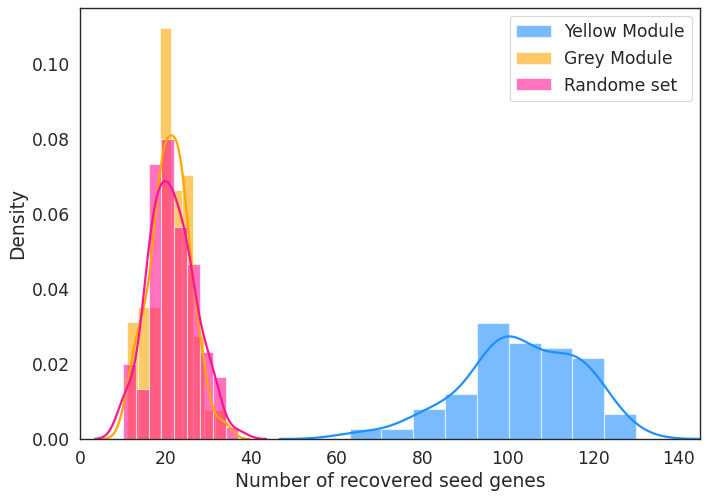

In [138]:

import seaborn as sns
sns.set_style("white")

 
Data1=results_D1_common
Data2=results_G1_common
Data3=results_All_common


# Plot
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

plt.figure(figsize=(10,7), dpi= 80)
sns.distplot(Data1, color="dodgerblue", label="Yellow Module", **kwargs)
sns.distplot(Data2, color="orange", label="Grey Module", **kwargs)
sns.distplot(Data3, color="deeppink", label="Randome set", **kwargs)
plt.xlim(0,145)
plt.xlabel('Number of recovered seed genes')
plt.ylabel('Density')

plt.legend();

In [ ]:
from collections import Counter


# Find the intersection
intersection = set(results_D1_common_Nodes[0]).intersection(*results_D1_common_Nodes)

# Convert the intersection back to a list (if needed)
intersection_list = list(intersection)


#print(intersection_list)




# Flatten the list of lists and count occurrences of each gene
all_genes = []
for sublist in results_D1_common_Nodes:
    for gene in sublist:
        all_genes.append(gene)


gene_counts = Counter(all_genes)

# Find genes that meet or exceed the threshold
overlap_genes = [gene for gene, count in gene_counts.items() if count >= 50]

print(overlap_genes)

In [104]:
import random
import openpyxl

random.seed(100)  # Replace 42 with any number to act as a seed

zthresh=2 # default = 3

results_D1kme_propag = []


results_D1kme_common = []

results_D1kme_common_Nodes = []


for x in range(10):
    
    print("Iteration",x, " *************************")
    
    
    # Select a random genes from the D1 as well as All genes
        
    D1kme_random = D1kme_df.sample(n=100)
    D1kme_random.index = D1kme_random['gene']
    D1kme_random_genes = D1kme_random.index.tolist()
    

    
    
    # Compute network proximity scores from tha random seed gene set as well as random all genes

    
    z_D1kme, Fnew_D1kme, Fnew_rand_D1kme = netprop_zscore.calculate_heat_zscores(w_double_prime, int_nodes, 
                                  dict(G_int.degree), D1kme_random_genes, 
                                   num_reps=10,  minimum_bin_size=100)
    z_D1kme = pd.DataFrame({'z':z_D1kme})
    

    
    
    
    
    # select the genes in the network intersection, make a subgraph
    G_Dkme_prox = nx.subgraph(G_int,z_D1kme[z_D1kme['z']>zthresh].index.tolist()) 

    
    
    
    
    D1_seed = set(D1_genes) - set(D1_random_genes)
    
    D1kme_uniq = set(G_Dkme_prox.nodes) - set(D1kme_random_genes,)
    
    D1kme_common = set(D1kme_uniq) & set(D1_seed)
    
    results_D1kme_common_Nodes.append(D1kme_common)
    
    
   
    results_D1kme_propag.append(len(G_Dkme_prox.nodes()))


    results_D1kme_common.append(len(D1kme_common))
    
    
    print("End of Iteration",x, " ******************")
    
    

  
data = {
'Nu.Propagated.D1KME': results_D1kme_propag,
'Nu.Common.D1KME': results_D1kme_common,

}


# Create a DataFrame from the dictionary
dff = pd.DataFrame(data)

# Save the DataFrame to an Excel file
dff.to_excel('Results_YellowKME.xlsx', index=False, engine='openpyxl')
  

Iteration 0  *************************


  0%|          | 0/10 [00:00<?, ?it/s]

End of Iteration 0  ******************
Iteration 1  *************************


  0%|          | 0/10 [00:00<?, ?it/s]

End of Iteration 1  ******************
Iteration 2  *************************


  0%|          | 0/10 [00:00<?, ?it/s]

End of Iteration 2  ******************
Iteration 3  *************************


  0%|          | 0/10 [00:00<?, ?it/s]

End of Iteration 3  ******************
Iteration 4  *************************


  0%|          | 0/10 [00:00<?, ?it/s]

End of Iteration 4  ******************
Iteration 5  *************************


  0%|          | 0/10 [00:00<?, ?it/s]

End of Iteration 5  ******************
Iteration 6  *************************


  0%|          | 0/10 [00:00<?, ?it/s]

End of Iteration 6  ******************
Iteration 7  *************************


  0%|          | 0/10 [00:00<?, ?it/s]

End of Iteration 7  ******************
Iteration 8  *************************


  0%|          | 0/10 [00:00<?, ?it/s]

End of Iteration 8  ******************
Iteration 9  *************************


  0%|          | 0/10 [00:00<?, ?it/s]

End of Iteration 9  ******************


In [109]:
from collections import Counter


# Find the intersection
intersection = set(results_D1kme_common_Nodes[0]).intersection(*results_D1kme_common_Nodes)

# Convert the intersection back to a list (if needed)
intersection_list = list(intersection)


#print(intersection_list)




# Flatten the list of lists and count occurrences of each gene
all_genes = []
for sublist in results_D1kme_common_Nodes:
    for gene in sublist:
        all_genes.append(gene)


gene_counts = Counter(all_genes)

# Find genes that meet or exceed the threshold
overlap_genes = [gene for gene, count in gene_counts.items() if count >= 5]

print(overlap_genes)

['CD2AP', 'GCH1', 'TMBIM4', 'FAM107B', 'CCNT2', 'KLF10', 'TOX4', 'KDM7A', 'DUSP5', 'BTG1', 'ATF3', 'KLHL2', 'TTC14', 'VPS4B', 'RO60', 'ZCCHC10', 'RBPJ', 'ZFX', 'GLIPR1', 'SNAP23', 'CASP6', 'TNKS2', 'MFSD14B', 'MAFF', 'CDC73', 'PRKCI', 'ATP13A3', 'WDR44', 'PLAU', 'CDR2', 'SEH1L', 'CEBPZ', 'USP7', 'DNAJB9', 'NOL11', 'LUC7L3', 'AGFG1', 'PRPF38B', 'PPP4R3A', 'UBE2J2', 'NUP153', 'MYNN', 'IL6', 'SERINC3', 'IL18R1', 'NFE2L2', 'RBM7', 'MED13', 'TTC33', 'B4GALT4', 'ZBTB11', 'CD46', 'DYRK1A', 'PPP1R2', 'AKIRIN2', 'MYSM1', 'TMEM165', 'FGFR1OP2', 'THOC2', 'RNF146', 'NUP50', 'MOB4', 'ZNF207', 'CHD9', 'SLC2A3', 'RBM6', 'HIVEP2', 'YIPF4', 'HEATR5B', 'ATP11B', 'IMPA1', 'UBE2D2', 'KDM3A', 'RNF11', 'ACTR3', 'FEM1C', 'PNRC1', 'MKX', 'PCNP', 'NUP107', 'CLDND1', 'SETD2', 'SYNCRIP', 'RGS2', 'CDK12', 'NRAS', 'ZNF410', 'B4GALT5', 'OSBPL8', 'MSL2', 'TNFAIP3', 'KMT5B', 'PRPF4B', 'PITPNB', 'EIF5', 'IFRD1', 'DDX3X', 'HSPA13', 'RNF138', 'SIRT1', 'ATP6V1C1', 'SERPINE1', 'CRBN', 'RBM27', 'TNFSF9', 'PPP4R2', 'RNGTT',

In [111]:
gene_counts

Counter({'CD2AP': 10,
         'TMBIM4': 10,
         'CCNT2': 10,
         'KDM7A': 10,
         'DUSP5': 10,
         'BTG1': 10,
         'ATF3': 10,
         'VPS4B': 10,
         'RO60': 10,
         'ZCCHC10': 10,
         'ZFX': 10,
         'GLIPR1': 10,
         'SNAP23': 10,
         'TNKS2': 10,
         'MAFF': 10,
         'CDC73': 10,
         'CEBPZ': 10,
         'USP7': 10,
         'LUC7L3': 10,
         'AGFG1': 10,
         'PRPF38B': 10,
         'PPP4R3A': 10,
         'NUP153': 10,
         'NFE2L2': 10,
         'RBM7': 10,
         'MED13': 10,
         'ZBTB11': 10,
         'CD46': 10,
         'DYRK1A': 10,
         'PPP1R2': 10,
         'AKIRIN2': 10,
         'TMEM165': 10,
         'THOC2': 10,
         'RNF146': 10,
         'NUP50': 10,
         'MOB4': 10,
         'ZNF207': 10,
         'CHD9': 10,
         'SLC2A3': 10,
         'HIVEP2': 10,
         'IMPA1': 10,
         'UBE2D2': 10,
         'KDM3A': 10,
         'RNF11': 10,
         'ACTR3': 1